In [227]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

load_dotenv()

True

In [201]:
conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    sslmode=os.getenv("DB_SSLMODE")
)

df = pd.read_sql("SELECT * FROM merged_stock_data_top", conn)

df.info()

/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_29379/2868224811.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM merged_stock_data_top", conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14938 entries, 0 to 14937
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               14938 non-null  object 
 1   stock_symbol       14938 non-null  object 
 2   open_price         14938 non-null  float64
 3   high_price         14938 non-null  float64
 4   low_price          14938 non-null  float64
 5   close_price        14938 non-null  float64
 6   adj_close          14938 non-null  float64
 7   volume             14938 non-null  float64
 8   article_sentiment  14938 non-null  float64
 9   article_count      14938 non-null  int64  
 10  sentiment_std      14938 non-null  float64
 11  hassentiment       14938 non-null  int64  
 12  gdp                14938 non-null  float64
 13  real_gdp           14938 non-null  float64
 14  unemployment_rate  14938 non-null  float64
 15  cpi                14938 non-null  float64
 16  fed_funds_rate     149

# EDA

In [202]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,stock_symbol,open_price,high_price,low_price,close_price,adj_close,volume,article_sentiment,article_count,sentiment_std,hassentiment,gdp,real_gdp,unemployment_rate,cpi,fed_funds_rate,sp500
0,2020-01-02,ADBE,330.000000,334.480011,329.170013,334.429993,334.429993,1990100.0,0.00,0,0.0,0,21933.217,20985.448,3.6,258.63,1.55,3257.85
1,2020-01-03,ADBE,329.170013,332.980011,328.690002,331.809998,331.809998,1577600.0,0.00,0,0.0,0,21933.217,20985.448,3.6,258.63,1.55,3234.85
2,2020-01-04,ADBE,329.170013,332.980011,328.690002,331.809998,331.809998,1577600.0,0.25,1,0.0,1,21933.217,20985.448,3.6,258.63,1.55,3234.85
3,2020-01-06,ADBE,328.290009,333.910004,328.190002,333.709991,333.709991,1874700.0,0.00,1,0.0,1,21933.217,20985.448,3.6,258.63,1.55,3246.28
4,2020-01-07,ADBE,334.149994,334.790009,332.309998,333.390015,333.390015,2500800.0,0.00,0,0.0,0,21933.217,20985.448,3.6,258.63,1.55,3237.18


Last available sentiment date: 2023-12-16
Filtered data up to: 2023-12-13, shape: (1389, 18)


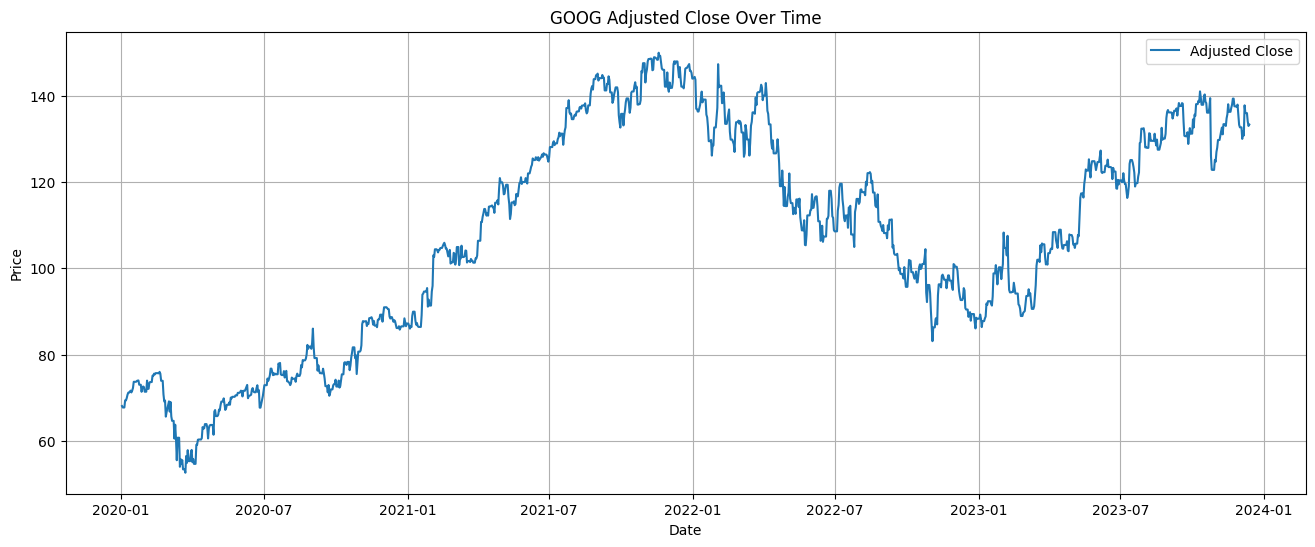

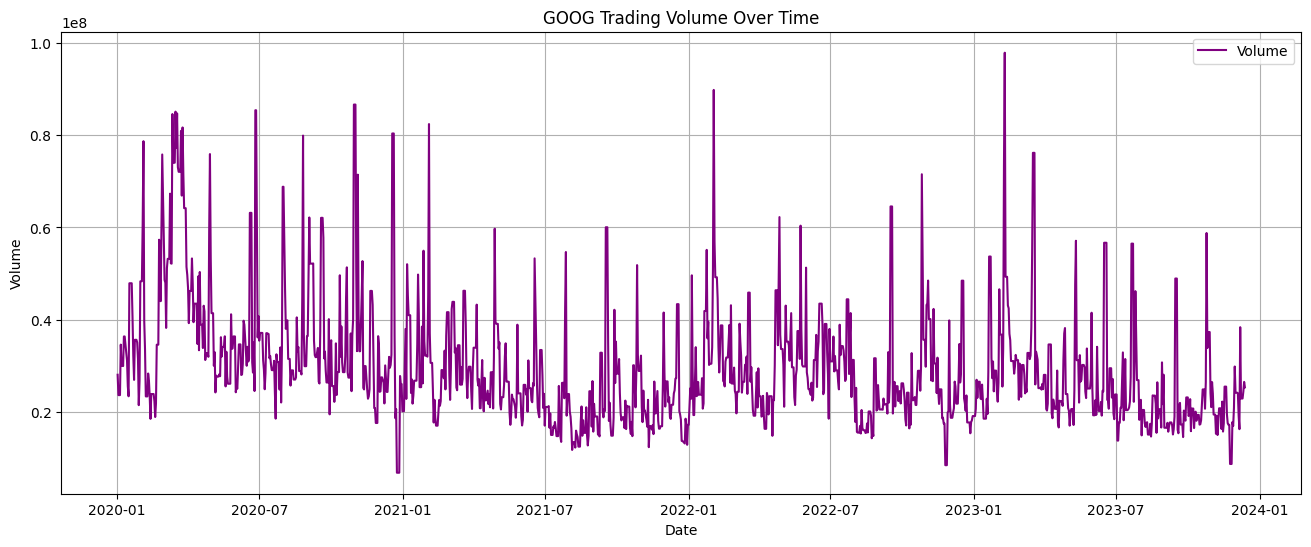

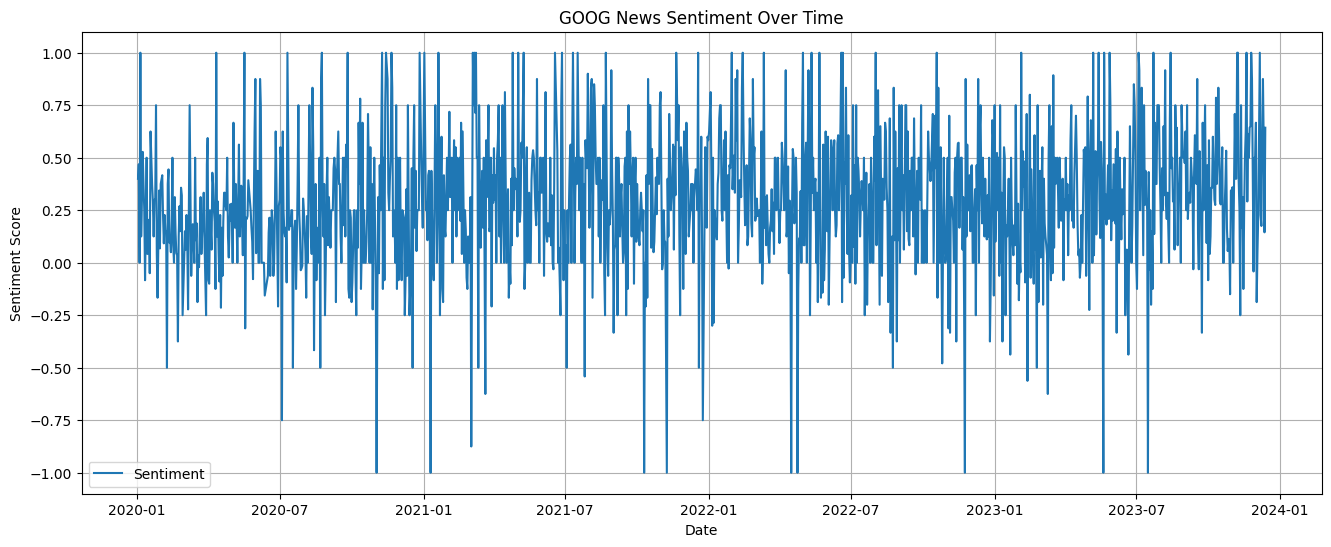

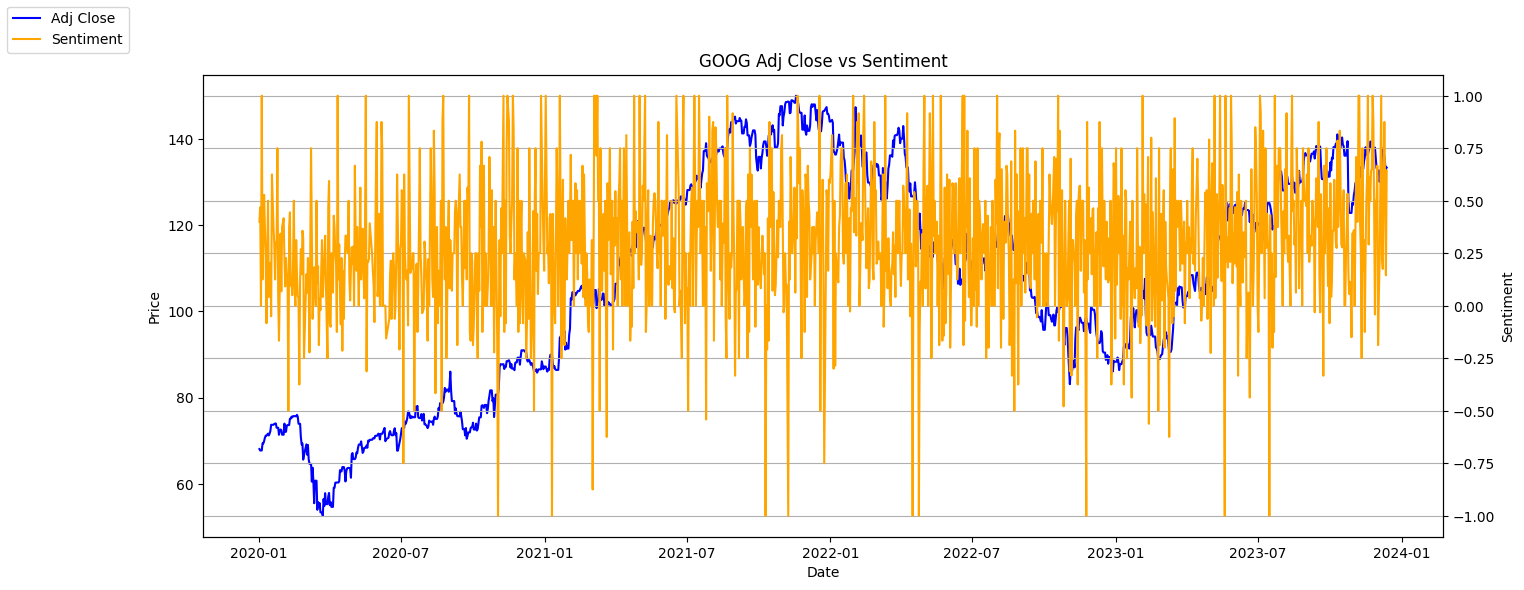

In [203]:
goog_df = df[(df['stock_symbol'] == 'GOOG')].copy()


last_sentiment_date = goog_df[goog_df['hassentiment'] == 1]['date'].max()
print(f"Last available sentiment date: {last_sentiment_date.date()}")

cutoff_date = last_sentiment_date - pd.Timedelta(days=3)
goog_df = goog_df[goog_df['date'] <= cutoff_date].copy()
print(f"Filtered data up to: {cutoff_date.date()}, shape: {goog_df.shape}")
goog_df.sort_values('date', inplace=True)
goog_df.reset_index(drop=True, inplace=True)
goog_df.set_index('date', inplace=True)

# === 1. Time Series Plots ===
plt.figure(figsize=(16, 6))
plt.plot(goog_df['adj_close'], label='Adjusted Close')
plt.title('GOOG Adjusted Close Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(goog_df['volume'], color='purple', label='Volume')
plt.title('GOOG Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(goog_df['article_sentiment'], label='Sentiment')
plt.title('GOOG News Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# Overlay Sentiment and Price
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()
ax1.plot(goog_df['adj_close'], label='Adj Close', color='blue')
ax2.plot(goog_df['article_sentiment'], label='Sentiment', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Sentiment')
plt.title("GOOG Adj Close vs Sentiment")
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

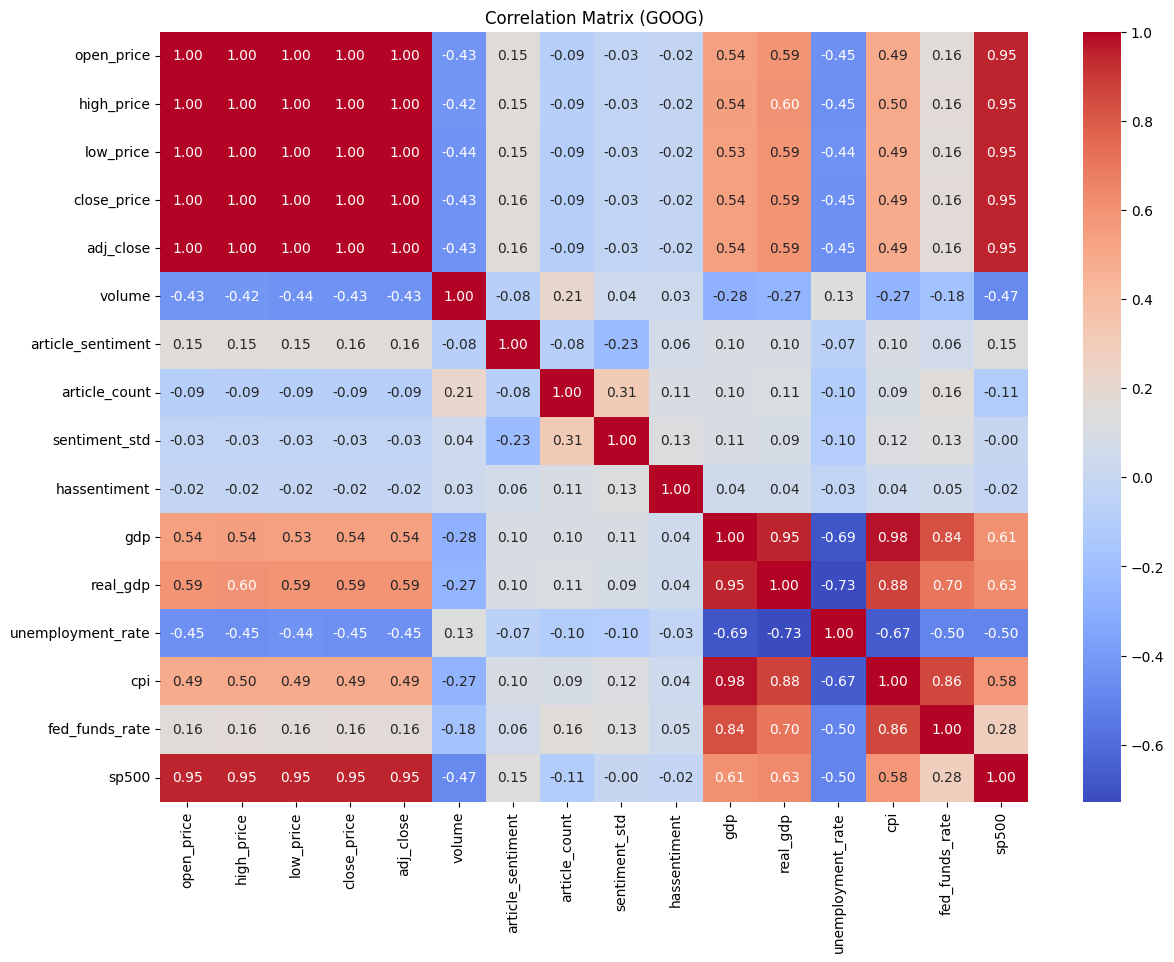

In [204]:
# === 2. Correlation Heatmap ===
plt.figure(figsize=(14, 10))
numeric_cols = goog_df.select_dtypes(include=[np.number]).columns
sns.heatmap(goog_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (GOOG)')
plt.show()

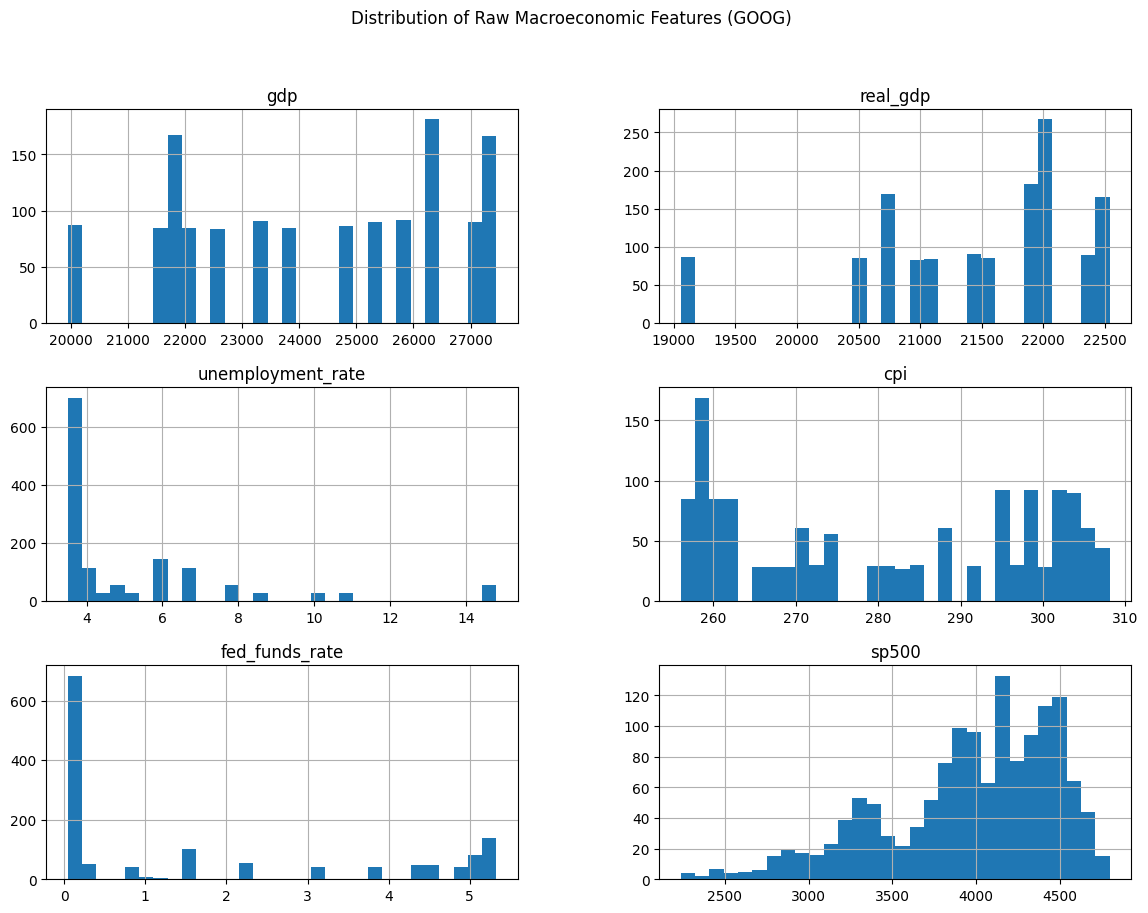

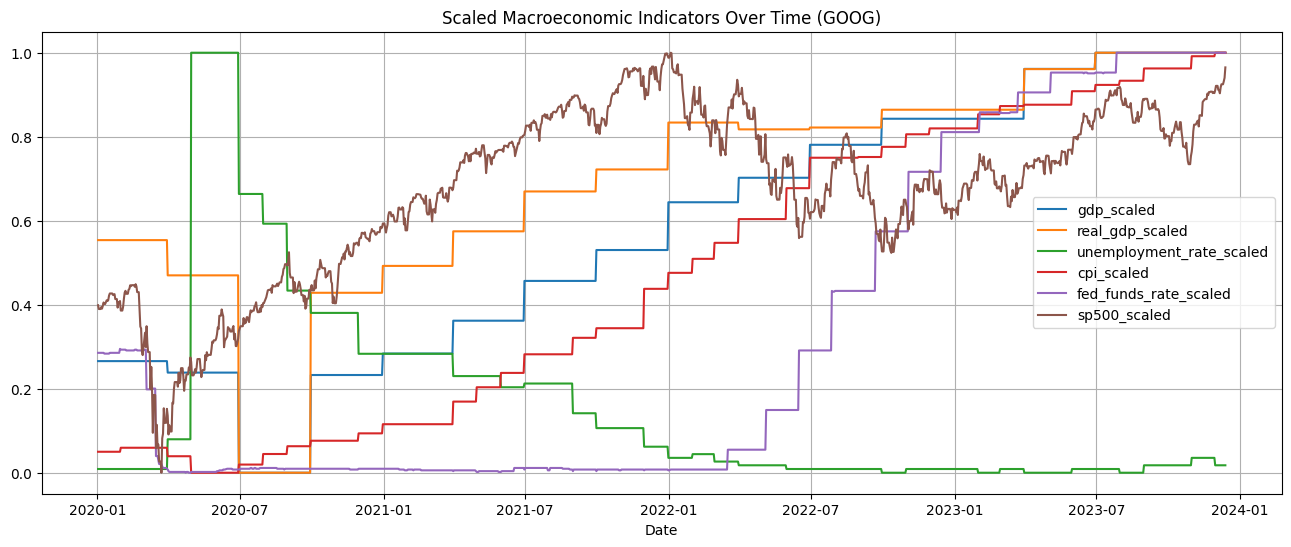

In [205]:
# === 3. Macro Feature Distributions ===
macro_features = ['gdp', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'sp500']

# Plot raw distributions
goog_df[macro_features].hist(bins=30, figsize=(14, 10))
plt.suptitle('Distribution of Raw Macroeconomic Features (GOOG)')
plt.show()

# === Scaling macro features for time series comparison ===
scaler = MinMaxScaler()
macro_scaled = pd.DataFrame(scaler.fit_transform(goog_df[macro_features]), 
                            columns=[f"{col}_scaled" for col in macro_features], 
                            index=goog_df.index)

# Concatenate scaled features with original dataframe if needed
goog_df_scaled = pd.concat([goog_df, macro_scaled], axis=1)

# === Plot Scaled Macros Over Time ===
plt.figure(figsize=(16, 6))
for col in macro_scaled.columns:
    plt.plot(macro_scaled.index, macro_scaled[col], label=col)
plt.legend()
plt.title('Scaled Macroeconomic Indicators Over Time (GOOG)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

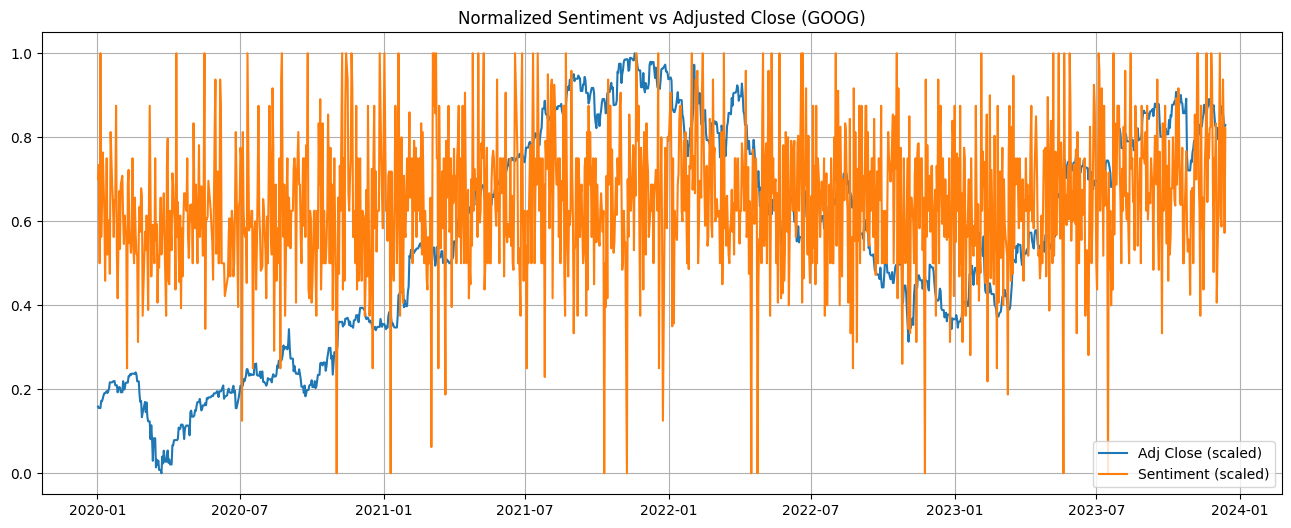

In [206]:
# === 4. Sentiment vs. 3-Day Future Return ===
goog_df['future_3d_return'] = goog_df['adj_close'].shift(-3) / goog_df['adj_close'] - 1
# Normalized overlay of sentiment and adj_close
scaler = MinMaxScaler()
scaled = scaler.fit_transform(goog_df[['adj_close', 'article_sentiment']])
goog_df['adj_close_scaled'] = scaled[:, 0]
goog_df['sentiment_scaled'] = scaled[:, 1]

plt.figure(figsize=(16, 6))
plt.plot(goog_df['adj_close_scaled'], label='Adj Close (scaled)')
plt.plot(goog_df['sentiment_scaled'], label='Sentiment (scaled)')
plt.title("Normalized Sentiment vs Adjusted Close (GOOG)")
plt.legend()
plt.grid(True)
plt.show()



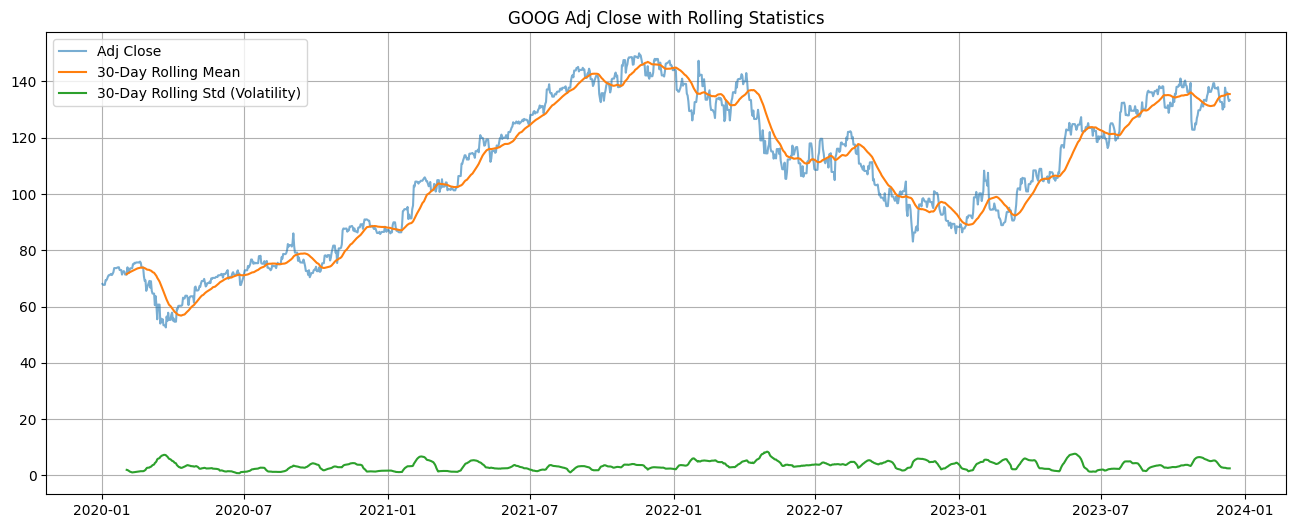

In [207]:
# === 5. Rolling Statistics ===
goog_df['rolling_mean_30'] = goog_df['adj_close'].rolling(window=30).mean()
goog_df['rolling_std_30'] = goog_df['adj_close'].rolling(window=30).std()

plt.figure(figsize=(16, 6))
plt.plot(goog_df['adj_close'], label='Adj Close', alpha=0.6)
plt.plot(goog_df['rolling_mean_30'], label='30-Day Rolling Mean')
plt.plot(goog_df['rolling_std_30'], label='30-Day Rolling Std (Volatility)')
plt.title('GOOG Adj Close with Rolling Statistics')
plt.legend()
plt.grid(True)
plt.show()



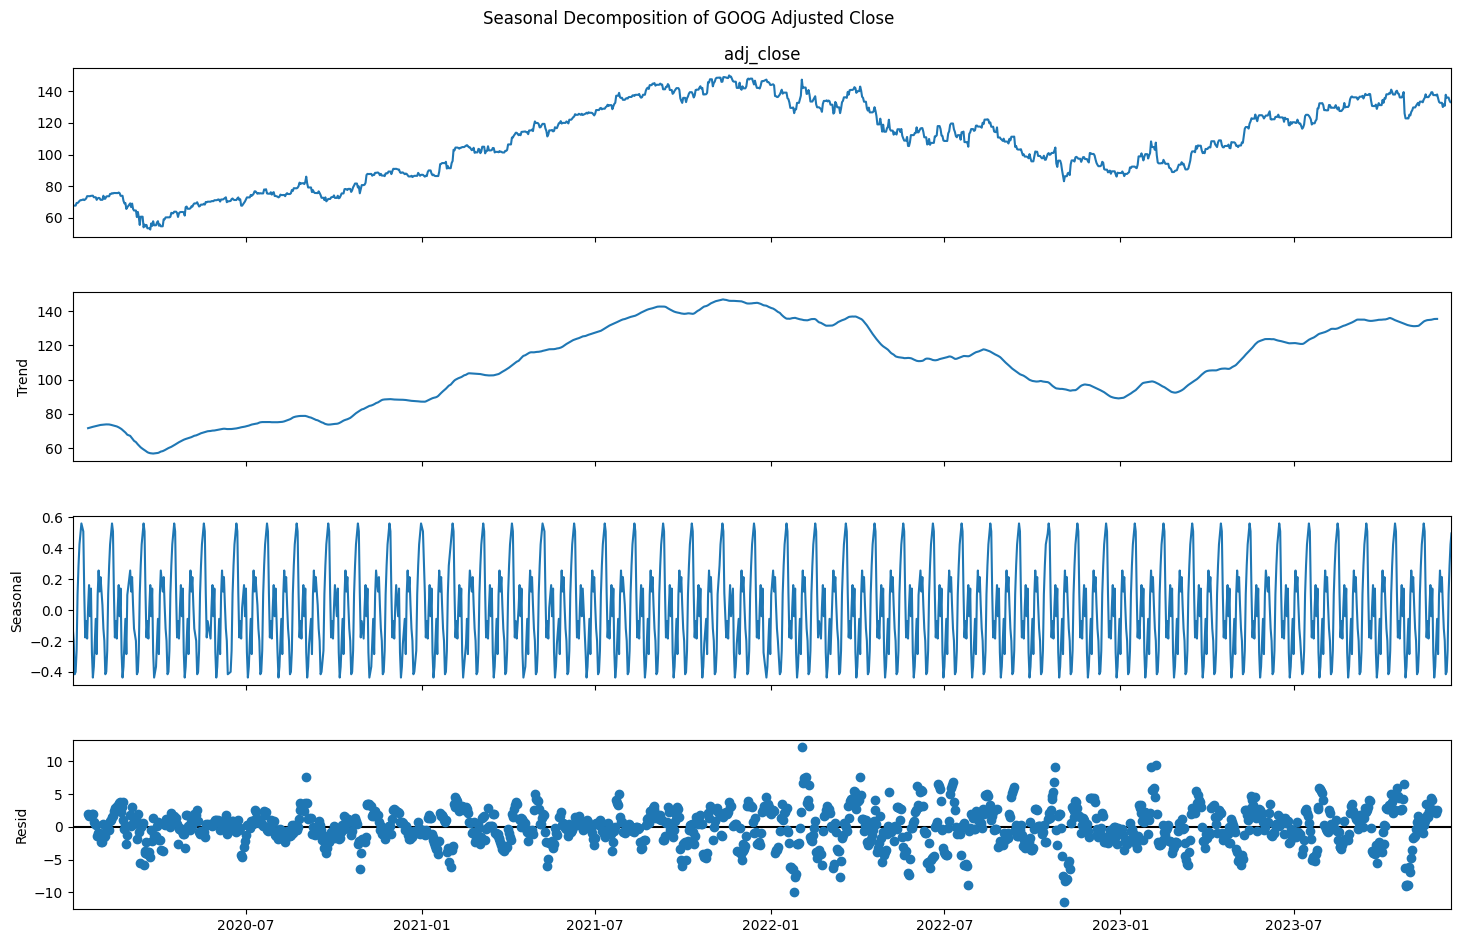

In [208]:
# === 6. Seasonal Decomposition ===
adj_close_cleaned = goog_df['adj_close'].dropna()
decomp = seasonal_decompose(adj_close_cleaned, model='additive', period=30)
fig = decomp.plot()
fig.set_size_inches(16, 10)
fig.suptitle("Seasonal Decomposition of GOOG Adjusted Close")
plt.show()

# Feature Engineering

In [209]:
goog_df_final = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_final.columns

Index(['date', 'stock_symbol', 'open_price', 'high_price', 'low_price',
       'close_price', 'adj_close', 'volume', 'article_sentiment',
       'article_count', 'sentiment_std', 'hassentiment', 'gdp', 'real_gdp',
       'unemployment_rate', 'cpi', 'fed_funds_rate', 'sp500'],
      dtype='object')

In [ ]:
# === Step 0: Create safe feature-engineered dataframe ===
goog_df_final = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_final['date'] = pd.to_datetime(goog_df_final['date'])
goog_df_final.sort_values('date', inplace=True)

# Create target (3-day future price)
forecast_horizon = 3
goog_df_final['adj_close_future_3d'] = goog_df_final['adj_close'].shift(-forecast_horizon)

# === Safe Feature Engineering ===
# 1. Lagged Features
lag_periods = [1, 2, 3, 5, 7]
for feature in ['adj_close', 'volume', 'article_sentiment']:
    for lag in lag_periods:
        goog_df_final[f'{feature}_lag_{lag}'] = goog_df_final[feature].shift(lag)

# 2. Volume Change Features (Added)
goog_df_final['volume_change_1d'] = goog_df_final['volume'].pct_change().shift(1)
goog_df_final['volume_change_3d'] = goog_df_final['volume'].pct_change(3).shift(1)
goog_df_final['volume_change_7d'] = goog_df_final['volume'].pct_change(7).shift(1)

# 3. Rolling Statistics (Past-Only)
for feature in ['adj_close', 'volume', 'article_sentiment']:
    for window in [3, 7, 14]:
        rolled = goog_df_final[feature].shift(1).rolling(window=window, min_periods=1)
        goog_df_final[f'{feature}_rollmean_{window}'] = rolled.mean()
        goog_df_final[f'{feature}_rollstd_{window}'] = rolled.std()

# 4. Momentum Indicators (Past-Only)
goog_df_final['past_1d_return'] = goog_df_final['adj_close'].pct_change(periods=1)
goog_df_final['past_3d_return'] = goog_df_final['adj_close'].pct_change(periods=3)
goog_df_final['past_7d_return'] = goog_df_final['adj_close'].pct_change(periods=7)

# 5. Volatility Features
goog_df_final['prev_close'] = goog_df_final['adj_close'].shift(1)
goog_df_final['true_range'] = goog_df_final.apply(
    lambda x: max(x['high_price']-x['low_price'],
                abs(x['high_price']-x['prev_close']),
                abs(x['low_price']-x['prev_close'])), axis=1)
goog_df_final['atr_7d'] = goog_df_final['true_range'].rolling(7).mean().shift(1)

# 6. Time Features
goog_df_final['day_of_week'] = goog_df_final['date'].dt.dayofweek
goog_df_final['month'] = goog_df_final['date'].dt.month
goog_df_final = pd.get_dummies(goog_df_final, columns=['day_of_week', 'month'], drop_first=True)
goog_df_final.dropna(inplace=True)

# === Step 1: Define columns to drop ===
explicit_drops = [
    'stock_symbol', 'open_price', 'high_price', 'low_price',
    'close_price', 'adj_close', 'prev_close', 'true_range',
]

# === Step 3: Time-based Split ===
train_end = '2022-12-31'
val_end = '2023-06-30'

train_df = goog_df_final[goog_df_final['date'] <= train_end].copy()
val_df = goog_df_final[(goog_df_final['date'] > train_end) & (goog_df_final['date'] <= val_end)].copy()
test_df = goog_df_final[goog_df_final['date'] > val_end].copy()

# === Step 4: Drop unwanted columns ===
train_df = train_df.drop(columns=explicit_drops, errors='ignore')
val_df = val_df.drop(columns=explicit_drops, errors='ignore')
test_df = test_df.drop(columns=explicit_drops, errors='ignore')

# === Step 5: Define target and features ===
target_col = 'adj_close_future_3d'
feature_cols = [col for col in train_df.columns if col not in [target_col, 'date']]

# === Step 6: Extract features and target ===
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_val, y_val = val_df[feature_cols], val_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# === Step 7: Scale numeric columns ===
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nNumber of features:", len(feature_cols))
print("Sample features:", feature_cols)  

Train period: 2020-01-10 to 2022-12-31 | Shape: (1036, 68)
Validation period: 2023-01-01 to 2023-06-30 | Shape: (180, 68)
Test period: 2023-07-01 to 2024-12-24 | Shape: (425, 68)

Number of features: 68
Sample features: ['volume', 'article_sentiment', 'article_count', 'sentiment_std', 'hassentiment', 'gdp', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'sp500', 'adj_close_lag_1', 'adj_close_lag_2', 'adj_close_lag_3', 'adj_close_lag_5', 'adj_close_lag_7', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3', 'volume_lag_5', 'volume_lag_7', 'article_sentiment_lag_1', 'article_sentiment_lag_2', 'article_sentiment_lag_3', 'article_sentiment_lag_5', 'article_sentiment_lag_7', 'volume_change_1d', 'volume_change_3d', 'volume_change_7d', 'adj_close_rollmean_3', 'adj_close_rollstd_3', 'adj_close_rollmean_7', 'adj_close_rollstd_7', 'adj_close_rollmean_14', 'adj_close_rollstd_14', 'volume_rollmean_3', 'volume_rollstd_3', 'volume_rollmean_7', 'volume_rollstd_7', 'volume_rollmean_14', 'volume

1. lagged versions of key features to help the model understand historical context:
	•	adj_close_lag_X: Closing price X days ago.
	•	volume_lag_X: Volume X days ago.
	•	article_sentiment_lag_X: Sentiment score X days ago.
These provide temporal patterns—i.e., how previous values relate to future prices.

2. percentage changes in volume:
	•	volume_change_1d: Yesterday’s volume change.
	•	volume_change_3d: Volume change over 3 days (ending yesterday).
	•	volume_change_7d: Volume change over 7 days (ending yesterday).
Why useful? Sudden volume changes often precede large price movements or volatility spikes.

3. moving averages and volatility indicators:
	•	*_rollmean_X: Rolling average over past X days (excluding today).
	•	*_rollstd_X: Rolling standard deviation over past X days (excluding today).
Rolling mean captures trend; rolling std captures volatility.

4. returns over different time horizons:
	•	past_1d_return: Daily return.
	•	past_3d_return: Return over past 3 days.
	•	past_7d_return: Return over past week.
Captures recent price momentum—essential for trend-following strategies.

5. Average True Range (ATR), a standard volatility indicator:
	•	true_range: Measures the most extreme price movement including gaps.
	•	atr_7d: 7-day average of true_range (ATR over 7 days).
High ATR → high volatility → possible market moves or reversals.

6. Time features
	•	day_of_week: From 0 (Monday) to 6 (Sunday) → one-hot encoded.
	•	month: Month number → one-hot encoded.
Helps capture weekly/monthly seasonality in stock behavior (e.g., “Monday effect”).

7. Target: adj_close_future_3d: Target for regression.

In [218]:
X_train_scaled.head()

,volume,article_sentiment,article_count,sentiment_std,hassentiment,gdp,real_gdp,unemployment_rate,cpi,fed_funds_rate,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
10251,0.413714,-0.083548,-0.318934,0.225997,0.082479,-0.747514,-0.230666,-0.763420,-1.018305,0.709330,...,False,False,False,False,False,False,False,False,False,False
10252,0.413714,-1.107553,-0.591105,0.726070,0.082479,-0.747514,-0.230666,-0.763420,-1.018305,0.709330,...,False,False,False,False,False,False,False,False,False,False
10253,0.162450,0.684455,-0.046763,0.100961,0.082479,-0.747514,-0.230666,-0.763420,-1.018305,0.709330,...,False,False,False,False,False,False,False,False,False,False
10254,0.023091,-0.723551,1.858435,0.581937,0.082479,-0.747514,-0.230666,-0.763420,-1.018305,0.709330,...,False,False,False,False,False,False,False,False,False,False
10255,-0.389018,-0.522407,0.497579,0.214439,0.082479,-0.747514,-0.230666,-0.763420,-1.018305,0.709330,...,False,False,False,False,False,False,False,False,False,False


# Baseline model

Linear Regression - MAE: 3.06, RMSE: 3.97, R²: 0.8894
Random Forest - MAE: 3.90, RMSE: 4.81, R²: 0.8375
Linear Regression - Directional Accuracy: 53.89%
Random Forest - Directional Accuracy: 41.11%


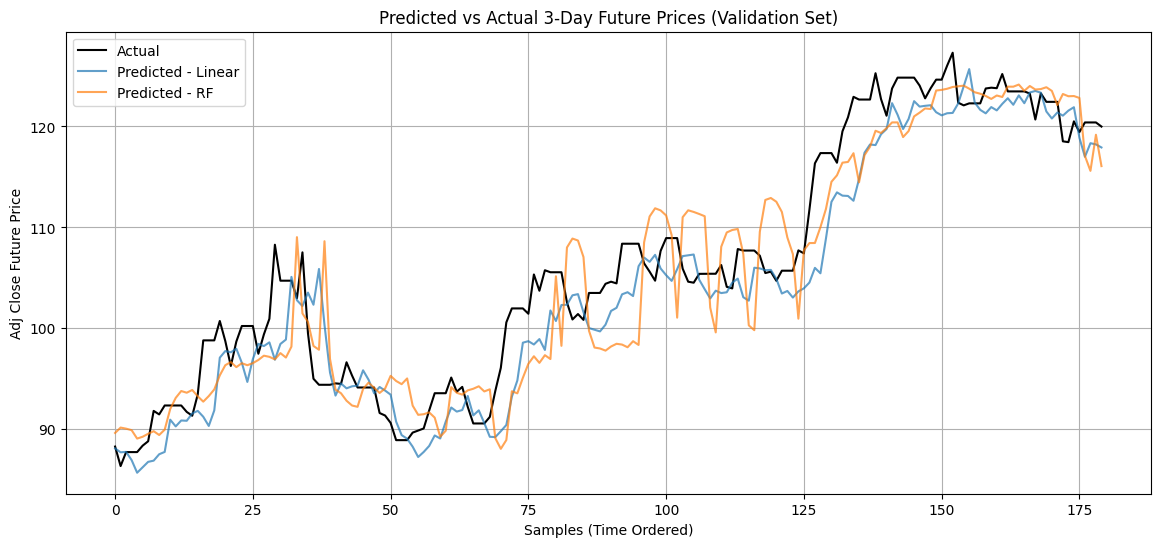

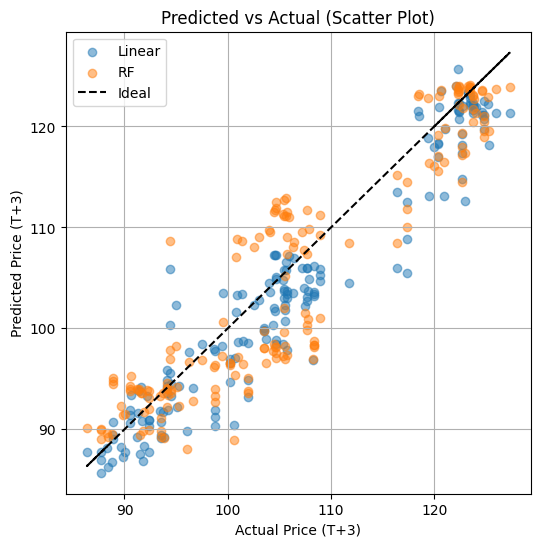

In [211]:
# === Step 1: Train Linear Regression and Random Forest ===
linreg = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

linreg.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# === Step 2: Predict on validation set ===
y_val_pred_linreg = linreg.predict(X_val_scaled)
y_val_pred_rf = rf.predict(X_val_scaled)

# === Step 3: Evaluation Metrics ===
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return mae, rmse, r2

evaluate_model(y_val, y_val_pred_linreg, "Linear Regression")
evaluate_model(y_val, y_val_pred_rf, "Random Forest")

# === Step 4: Directional Accuracy (based on predicted vs actual return direction) ===
# Calculate actual 3-day return direction
actual_return = y_val.values - X_val['adj_close_lag_1'].values
pred_linreg_return = y_val_pred_linreg - X_val['adj_close_lag_1'].values
pred_rf_return = y_val_pred_rf - X_val['adj_close_lag_1'].values

dir_acc_linreg = np.mean(np.sign(actual_return) == np.sign(pred_linreg_return))
dir_acc_rf = np.mean(np.sign(actual_return) == np.sign(pred_rf_return))

print(f"Linear Regression - Directional Accuracy: {dir_acc_linreg:.2%}")
print(f"Random Forest - Directional Accuracy: {dir_acc_rf:.2%}")

# === Step 6: Visualization - Actual vs Predicted over time ===
plt.figure(figsize=(14, 6))
plt.plot(y_val.values, label='Actual', color='black')
plt.plot(y_val_pred_linreg, label='Predicted - Linear', alpha=0.7)
plt.plot(y_val_pred_rf, label='Predicted - RF', alpha=0.7)
plt.title("Predicted vs Actual 3-Day Future Prices (Validation Set)")
plt.xlabel("Samples (Time Ordered)")
plt.ylabel("Adj Close Future Price")
plt.legend()
plt.grid(True)
plt.show()

# === Step 7: Scatter Plot - Predicted vs Actual ===
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred_linreg, label='Linear', alpha=0.5)
plt.scatter(y_val, y_val_pred_rf, label='RF', alpha=0.5)
plt.plot(y_val, y_val, color='black', linestyle='--', label='Ideal')
plt.xlabel("Actual Price (T+3)")
plt.ylabel("Predicted Price (T+3)")
plt.title("Predicted vs Actual (Scatter Plot)")
plt.legend()
plt.grid(True)
plt.show()

# Model Interpretability 

In [214]:
# === 1. Random Forest Feature Importance ===
rf_importances = rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Format to decimals (e.g., 0.000523 instead of 5.23e-04)
pd.options.display.float_format = '{:.6f}'.format

print("\nRandom Forest Feature Importances:")
print(rf_importance_df.to_string(index=False))

# === 2. Linear Regression Coefficients ===
linreg_coefs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

print("\nLinear Regression Coefficients:")
print(linreg_coefs.to_string(index=False))

# (Optional) Reset float display to default after this if needed:
# pd.reset_option('display.float_format')


Random Forest Feature Importances:
                      Feature  Importance
              adj_close_lag_1    0.597066
         adj_close_rollmean_3    0.181240
              adj_close_lag_2    0.108763
         adj_close_rollmean_7    0.073793
              adj_close_lag_3    0.011095
                        sp500    0.007428
        adj_close_rollmean_14    0.005638
           volume_rollmean_14    0.001219
            volume_rollmean_7    0.000970
            volume_rollstd_14    0.000899
              adj_close_lag_5    0.000851
                       atr_7d    0.000792
 article_sentiment_rollstd_14    0.000714
               fed_funds_rate    0.000706
         adj_close_rollstd_14    0.000642
article_sentiment_rollmean_14    0.000613
               past_3d_return    0.000577
               past_7d_return    0.000498
               past_1d_return    0.000439
                          cpi    0.000339
 article_sentiment_rollmean_7    0.000328
            unemployment_rate    0.00031

In [215]:
# Threshold for minimum importance to keep
importance_threshold = 0.0005

selected_features = rf_importance_df[rf_importance_df['Importance'] >= importance_threshold]['Feature'].tolist()

print(f"\nSelected {len(selected_features)} features (importance ≥ {importance_threshold}):")
print(selected_features)

# Reduce feature sets
X_train_sel = X_train_scaled[selected_features]
X_val_sel = X_val_scaled[selected_features]
X_test_sel = X_test_scaled[selected_features]


Selected 17 features (importance ≥ 0.0005):
['adj_close_lag_1', 'adj_close_rollmean_3', 'adj_close_lag_2', 'adj_close_rollmean_7', 'adj_close_lag_3', 'sp500', 'adj_close_rollmean_14', 'volume_rollmean_14', 'volume_rollmean_7', 'volume_rollstd_14', 'adj_close_lag_5', 'atr_7d', 'article_sentiment_rollstd_14', 'fed_funds_rate', 'adj_close_rollstd_14', 'article_sentiment_rollmean_14', 'past_3d_return']



=== Test Set Evaluation ===
Linear Regression - MAE: 4.04, RMSE: 26.54, R²: 0.9351
Random Forest - MAE: 13.28, RMSE: 346.51, R²: 0.1525
Linear Regression - Directional Accuracy: 42.92%
Random Forest - Directional Accuracy: 38.44%
Naive Forecast (No Change) - MAE: 3.83, RMSE: 25.31, R²: 0.9381
Naive Forecast - Directional Accuracy: 39.86%


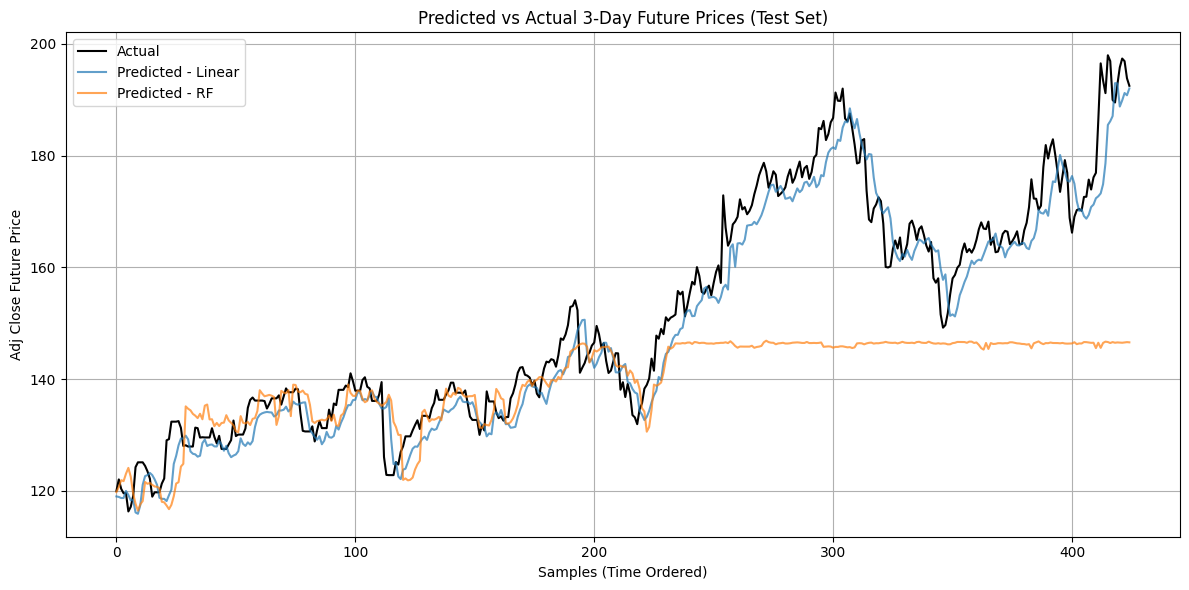

In [217]:
# Retrain models on selected features
linreg_sel = LinearRegression()
rf_sel = RandomForestRegressor(n_estimators=100, random_state=42)

linreg_sel.fit(X_train_sel, y_train)
rf_sel.fit(X_train_sel, y_train)

# === 1. Predict on Test Set ===
y_pred_lr_test_sel = linreg_sel.predict(X_test_sel)
y_pred_rf_test_sel = rf_sel.predict(X_test_sel)

# === 2. Evaluation Metrics ===
def evaluate(y_true, y_pred, name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return mae, rmse, r2

print("\n=== Test Set Evaluation ===")
evaluate(y_test, y_pred_lr_test_sel, name="Linear Regression")
evaluate(y_test, y_pred_rf_test_sel, name="Random Forest")

# === 3. Directional Accuracy ===
def directional_accuracy(y_true, y_pred, base=None):
    actual_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    accuracy = (actual_direction == pred_direction).mean() * 100
    return round(accuracy, 2)

print(f"Linear Regression - Directional Accuracy: {directional_accuracy(y_test.values, y_pred_lr_test_sel)}%")
print(f"Random Forest - Directional Accuracy: {directional_accuracy(y_test.values, y_pred_rf_test_sel)}%")

# === 4. Naive Baseline (No Change) ===
y_naive = X_test['adj_close_lag_1'].values  # naive: 3-day future price = today's price
evaluate(y_test, y_naive, name="Naive Forecast (No Change)")
print(f"Naive Forecast - Directional Accuracy: {directional_accuracy(y_test.values, y_naive)}%")

# === 5. Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_lr_test_sel, label='Predicted - Linear', alpha=0.7)
plt.plot(y_pred_rf_test_sel, label='Predicted - RF', alpha=0.7)
plt.title('Predicted vs Actual 3-Day Future Prices (Test Set)')
plt.xlabel('Samples (Time Ordered)')
plt.ylabel('Adj Close Future Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM 

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 11812.7334 - mae: 105.5532 - val_loss: 10792.8613 - val_mae: 103.2935 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10837.7588 - mae: 101.1744 - val_loss: 9186.4268 - val_mae: 95.1681 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9104.2764 - mae: 92.1036 - val_loss: 7572.4609 - val_mae: 86.2685 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7178.3511 - mae: 80.5205 - val_loss: 5916.9717 - val_mae: 76.0707 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5492.4546 - mae: 69.3307 - val_loss: 4281.0146 - val_mae: 64.4267 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4316.9717 - mae: 59.6901 - val_loss: 2902.6768 - val_mae: 52.6541 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3043.4900 - mae: 47.9121 - val_loss: 1826.8597

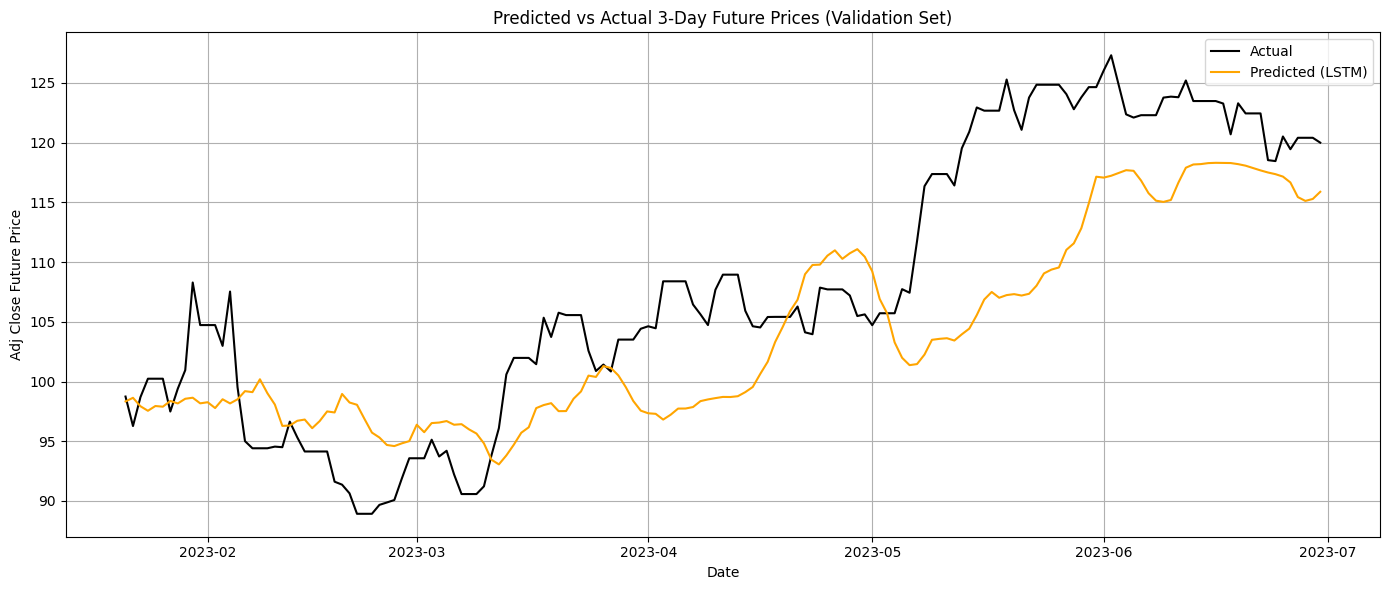

In [228]:

# === PARAMETERS ===
LOOKBACK = 20  # Number of past days as input
BATCH_SIZE = 32
EPOCHS = 100

# === STEP 1: Recreate supervised learning sequences ===
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# === STEP 2: Scale features ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Ensure float32 for Keras compatibility
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

# === STEP 3: Create LSTM input sequences ===
X_train_seq, y_train_seq = create_sequences(X_train_scaled.values, y_train.values, LOOKBACK)
X_val_seq, y_val_seq = create_sequences(X_val_scaled.values, y_val.values, LOOKBACK)
X_test_seq, y_test_seq = create_sequences(X_test_scaled.values, y_test.values, LOOKBACK)

# === STEP 4: Build the model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train_seq.shape[2]), dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# === STEP 5: Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === STEP 6: Evaluation ===
val_preds = model.predict(X_val_seq).flatten()
print("Validation MAE:", mean_absolute_error(y_val_seq, val_preds))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val_seq, val_preds)))
print("Validation R²:", r2_score(y_val_seq, val_preds))

# === STEP 7: Visualization ===
plot_df = val_df.iloc[LOOKBACK:].copy()
plot_df['Actual'] = y_val_seq
plot_df['Predicted'] = val_preds

plt.figure(figsize=(14, 6))
plt.plot(plot_df['date'], plot_df['Actual'], label='Actual', color='black')
plt.plot(plot_df['date'], plot_df['Predicted'], label='Predicted (LSTM)', color='orange')
plt.title('Predicted vs Actual 3-Day Future Prices (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Adj Close Future Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Why a Linear Model Might Outperform an LSTM (Short Horizon Challenges)

In short-term stock forecasting (e.g. predicting 3 days ahead), it’s not uncommon for a simple model (like linear regression or even a “no-change” random walk) to beat a complex LSTM. There are several reasons for this underperformance:
	•	Market Randomness: Financial price movements often resemble a random walk – past prices alone may carry little predictive signal for the near future ￼. If true, an LSTM trained only on historical prices is trying to find patterns that might not exist, while a linear model that essentially extrapolates the recent trend or assumes minimal change can perform just as well or better by not overfitting noise. As one analysis put it, if stock prices are essentially random and “historical information has no bearing on a stock’s future movement,” then “an LSTM using historical price movement to predict future ones” is fundamentally challenged ￼.
	•	High Variance vs. Low Variance: LSTMs are high-capacity models with many parameters. They can overfit small datasets, learning spurious patterns. A linear model has far fewer parameters and is less prone to overfitting on limited data. With only a few years of daily data (perhaps ~750–1000 trading days), a complex LSTM can easily memorize noise unless heavily regularized. Simpler models “need fewer data to converge” and may outperform a complex LSTM when data is limited ￼. In other words, the LSTM’s flexibility is an advantage only if sufficient data or true patterns exist – otherwise the linear model’s simplicity is a strength.
	•	Short-Term Dynamics: For very short horizons like 3 days ahead, there might be only modest linear autocorrelations (e.g. momentum or mean reversion) that a linear model can capture. LSTMs excel at learning complex nonlinear temporal dependencies, but if the target pattern is essentially linear or very weak, the LSTM may not have an edge. In fact, a well-tuned LSTM might end up approximating something close to the linear relationship anyway, but with more difficulty. Any slight mismatch can hurt accuracy.
	•	Training Difficulty: LSTMs require careful tuning (learning rate, architecture, etc.). If not optimized well, they might underperform a more straightforward method. For example, using an improper sequence length or suboptimal hyperparameters could hamper LSTM performance, giving an edge to a plug-and-play linear regression. We address these considerations below.

Despite these challenges, LSTMs can outperform linear models when properly utilized – numerous studies have found advanced LSTM-based models consistently beating linear methods for stock prediction ￼. The key is to mitigate overfitting and make the most of LSTM’s strengths. Below, we outline best practices to improve LSTM performance in short-horizon stock forecasting.